# Practical session 02 - barrista

This notebook is for use in the Max-Planck ETH Center for Learning Systems workshop on Deep Learning (July 11th-13th 2016, Donaueschingen) only. Author: Christoph Lassner.

**All IPython notebooks are stored read-only. You can create your own, writeable copy by using "File" -> "Make a copy...".**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1 - Finding your way around barrista

### Providing the barrista with caffe

Barrista can work with any caffe version since June 2015. You just have to tell it which one to use. There are three ways to do so:

1. Edit the source files,
2. do it on-the-fly in the code,
3. set environment variables (`CAFFE_BIN_FOLDER` and `CAFFE_PYTHON_FOLDER`).

The installation for this tutorial is already configured, but for the sake of completion, we'll illustrate how to configure barrista on-the-fly.

The configuration is stored in the `barrista.config` module. Just import this module first, before any other `caffe` or `barrista` import and adjust the configuration:

In [2]:
import barrista.config as cfg

In [3]:
cfg.CAFFE_BIN_FOLDER = '/home/barrista/barrista/caffe/build/install/bin'
cfg.CAFFE_PYTHON_FOLDER = '/home/barrista/barrista/caffe/build/install/python/'

Apart from the two used properties, there is a third, `barrista.config.LAYER_TYPES`, which can be used to register your custom caffe layers. We will come back to this later.

## Module overview

With the configuration done, you can import all barrista modules using the correct caffe compilation. The modules and their content is as follows:

* `barrista.config`: The configuration variables, as you know already.
* `barrista.design`: Tools to design networks.
* `barrista.monitoring`: Callbacks for the training and testing, including pre-processing and logging.
* `barrista.net`: The instantiated net class and its methods, e.g., `net.predict`.
* `barrista.solver`: Solvers and the `fit` method implementation.

In barrista, a network has two describing objects: a `barrista.design.NetSpecification` object that *describes* the network and, on instantiation, a `barrista.net.Net` object, representing the instantiated model with all parameters and application functions.

-------------------------------------

## Part 2 - Designing a network

In a first step, we will design and analyze a basic linear unit, then two units with a non-linearity, before we move on to state-of-the art residual networks later in this session. All net design related tools can be found in the `barrista.design` module:

In [4]:
import barrista.design as ds

The following code creates a `NetSpecification` object:

In [5]:
# The only required parameter is a list of lists with the input shape
# specification for the network. In this case, we also specify names
# for the inputs layers. This creates a network with batch size 10,
# and 1-layer 1x2 input, including annotation labels.
netspec = ds.NetSpecification([[4, 1, 1, 2], [4]],
                              inputs=['data', 'labels'],
                              predict_input_shapes=[[4, 1, 1, 2],],
                              predict_inputs=['data'])

In [6]:
# The most important property  of the net specification for the network
# design is the `layers`. It is a list of layer objects, which is empty
# at the beginning (but you can always assume that the bottoms specified
# as `inputs` during construction of the NetSpecification object are
# always available). Let's add a linear unit:
netspec.layers.append(
    ds.InnerProductLayer(
        name='fc1',
        bottoms=['data'],
        InnerProduct_weight_filler=ds.PROTODETAIL.FillerParameter(type='gaussian', std=0.01),
        InnerProduct_num_output=2))
# This adds a softmax layer with loss computation:
netspec.layers.append(
    ds.SoftmaxWithLossLayer(
        name='loss',
        bottoms=['fc1', 'labels'],
        include_stages=['fit']))
netspec.layers.append(
    ds.SoftmaxLayer(
        name='class',
        bottoms=['fc1'],
        include_stages=['predict']))

With this, the network specification is complete (no prototxt involved ;) ). Let's instantiate the network and play with it! But before, let's check on a visualization whether everything was realized as expected:

In [7]:
visualization = netspec.visualize(display=False)

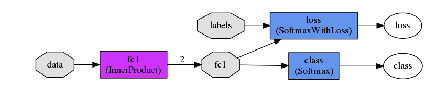

In [8]:
plt.figure(figsize=(7,2))
plt.imshow(visualization[:, :, ::-1], interpolation='none')
plt.axis('off'); plt.show()

------------------------------

## Part 3 - Working with `Net`s

In [9]:
netspec.phase = ds.PROTODETAIL.TRAIN
net = netspec.instantiate()

The `barrista.net.Net` object provides access to all related properties of a concrete model instantiation. Additionally, it offers an interface to `fit` the model parameters, as well as to `predict` results for new data.

The object inherits from the `caffe.Net` object, hence offers the well-known, low-level interface. In contrast, the provided new `fit` and `predict` methods abstract away from the NN nature of the model and try to offer a high convenience, yet high adjustability, e.g., you do not have to care about batching. Let's check this:

In [10]:
from barrista import solver
from barrista.monitoring import ProgressIndicator, Checkpointer

In [11]:
# Handy code for visualization. Ignore for now!
def visualize_decider(dec_func, training_data=None, annotations=None,
                      x_offset=[-1.,1.], y_offset=[-1.,1], transpose=False,
                      num_samples=10):
    """
    Visualizes a decision boundary.
    """
    if training_data is None:
        x = np.linspace(x_offset[0], x_offset[1], num_samples)
        y = np.linspace(y_offset[0], y_offset[1], num_samples)
    else :
        x = np.linspace(min(training_data[:, 0]) + x_offset[0], max(training_data[:, 0]) + x_offset[1], num_samples)
        y = np.linspace(min(training_data[:, 1]) + y_offset[0], max(training_data[:, 1]) + y_offset[1], num_samples)
    # Create the meshgrid
    X, Y = np.meshgrid(x, y)
    Z = np.array(zip(X.flat, Y.flat), dtype='float32')
    Z = Z.reshape((Z.shape[0], 1, 1, 2))
    Z = dec_func(Z)[:, 1].reshape((X.shape))
    # Plot the contours
    contourplot = plt.contour(X, Y, Z)
    plt.clabel(contourplot, inline=1, fontsize=10)
    # Plot the data if available
    if training_data is not None and annotations is not None:
        plt.scatter(training_data[:, 0], training_data[:, 1],
                    c=annotations)
    return contourplot
        
import barrista.monitoring as mtr
class nbvislzr(mtr.Monitor):
    def __init__(self, full_model):
        self.full_model = full_model
    
    def _post_test_batch(self, kwargs):
        from IPython import display
        plt.gca().cla()
        visualize_decider(
            lambda x: np.array(self.full_model.predict(x)),
            X, Y, num_samples=5)
        plt.title('Model after %d iterations' % kwargs.get('iter', 0))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    def finalize(self, kwargs):
        from IPython import display
        plt.gca().cla()
        display.clear_output()
        visualize_decider(
            lambda x: np.array(self.full_model.predict(x)),
            X, Y, num_samples=5)
        plt.title('Model after %d iterations' % kwargs.get('iter', 0))

In [12]:
X = np.array([[-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]], dtype='float32')
Y = np.array([[0, 0, 0, 1],], dtype='float32').T

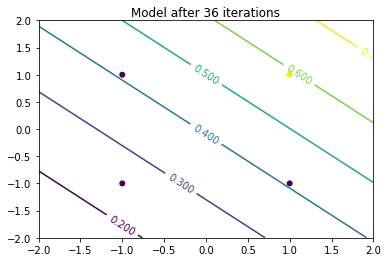

In [13]:
# Configure our monitors.
progress = ProgressIndicator()
checkptr = Checkpointer('test_net_', 48)
# Run the training.
net.fit(36,
        solver.SGDSolver(base_lr=0.1, snapshot_prefix='test_net_'),
        {'data': X,  # 'data' and 'annotations' are the input layer names.
         'labels': Y}, # optional (if you have, e.g., a DataLayer)
        test_interval=4,  # optional
        X_val={'data': X,  # optional
               'labels': Y},
        train_callbacks=[],  # optional
        test_callbacks=[nbvislzr(net)])  # optional

### Exercise 1

* Explore the net object: how can you access 
    - the parameters of the fc1 layer and
    - the output of the fc1 layer, before being processed by the softmax layer?
  Can you plot a histogram of the values?

* Play around with the classes of the four values. How can you most elegantly solve problems that are unsolvable by the linear unit currently used?

---------------------------------------

## Part 4 - Moving towards larger networks

This section deals with creating deeper networks, where procedural generation becomes increasingly important. For example the 151 layer residual network prototxt specification has more than 6000 lines. This makes maintenance very error prone and small changes hard to implement. In contrast, we will create the code for residual networks of arbitrary depths with few lines of Python code. At the same time, I'll introduce the notion of 'fit' and 'predict' architectures, that can be nicely summarized using barrista.

First, let's look at the residual layer design:

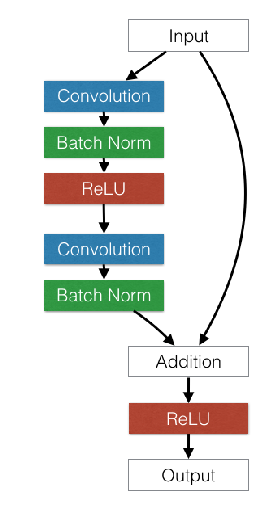

In [5]:
VISIM = cv2.imread('support-material/residual-layer.png')[:, :, ::-1]
plt.figure(figsize=(4, 10)); plt.imshow(VISIM); plt.axis('off'); plt.show()

The trick is to only learn the difference that must be added to the input. Du to the usually used $L_1$ or $L_2$ regularizers, this facilitates learning of identity relations, and such the training of deeper networks.

The code to create a residual unit is quite straightforward, with the exception of a unit where pooling is used in the end and an additional scaling 'sidepath' must be learned:

In [6]:
# This is just to ensure always new layer ids for new generated
# residual blocks.
_l_idx = 0

def ResBlock(n_in, in_name, n_out, stride=1):
    """Create a residual block."""
    global _l_idx
    layers = []
    layers.append(_ds.ConvolutionLayer(
        name='resblock{}_conv1'.format(_l_idx),
        bottoms=[in_name],
        Convolution_num_output=n_out,
        Convolution_kernel_size=(3, 3),
        Convolution_stride=(stride, stride),
        Convolution_pad=(1, 1),
        Convolution_weight_filler=_ds.PROTODETAIL.FillerParameter(type='msra')
    ))
    layers.append(_ds.BatchNormLayer(
        name='resblock{}_bn1'.format(_l_idx),
        BatchNorm_moving_average_fraction=0.9
    ))
    layers.append(_ds.ScaleLayer(
        name='resblock{}_scale1'.format(_l_idx),
        Scale_bias_term=True
    ))
    layers.append(_ds.ReLULayer(name='resblock{}_relu1'.format(_l_idx)))
    layers.append(_ds.ConvolutionLayer(
        Convolution_num_output=n_out,
        Convolution_kernel_size=(3, 3),
        Convolution_pad=(1, 1),
        Convolution_weight_filler=_ds.PROTODETAIL.FillerParameter(type='msra')
    ))
    layers.append(_ds.BatchNormLayer(
        name='resblock{}_bn2'.format(_l_idx),
        BatchNorm_moving_average_fraction=0.9
    ))
    layers.append(_ds.ScaleLayer(
        name='resblock{}_scale2'.format(_l_idx),
        Scale_bias_term=True
    ))
    # Collect the names of the inputs to the sum operation.
    sum_in = [in_name, 'resblock{}_scale2'.format(_l_idx)]
    if n_in != n_out:
        layers.append(_ds.ConvolutionLayer(
            name='resblock{}_sidepath'.format(_l_idx),
            bottoms=[in_name],
            Convolution_num_output=n_out,
            Convolution_kernel_size=(1, 1),
            Convolution_stride=(stride, stride),
        ))
        sum_in[0] = 'resblock{}_sidepath'.format(_l_idx)
    layers.append(_ds.EltwiseLayer(
        name='resblock{}_sum'.format(_l_idx),
        bottoms=sum_in,
        Eltwise_operation=_ds.PROTODETAIL.EltwiseParameter.SUM))
    layers.append(_ds.ReLULayer(name='resblock{}_out'.format(_l_idx)))
    _l_idx += 1
    return layers, 'resblock{}_out'.format(_l_idx - 1)

This allows to create residual networks of arbitrary depths in just 60 lines, and with a much better understanding what's going on. Let's do this and stick exactly with the specification of Microsoft Research. Their residual nets have three 'parts' where after each part, the input size is halved. One block has (with Microsoft counting) 5 layers, meaning that the total depth can be calculated as $blocks\_per\_part * 5 + 6$ layers. The full definition can be along the lines of

In [7]:
_layers = []
_ds = ds
def construct_resnet(blocks_per_part):
    _layers.append(_ds.ConvolutionLayer(
        name='conv_initial',
        bottoms=['data'],
        Convolution_num_output=16,
        Convolution_kernel_size=(3, 3),
        Convolution_pad=(1, 1),
        Convolution_weight_filler=_ds.PROTODETAIL.FillerParameter(
            type='msra')))
    _layers.append(_ds.BatchNormLayer(
        name='bn_initial',
        BatchNorm_moving_average_fraction=0.9
    ))
    _layers.append(_ds.ScaleLayer(
        name='scale_initial',
        Scale_bias_term=True
    ))
    _layers.append(_ds.ReLULayer(name='relu_initial'))
    last_out = 'relu_initial'
    for i in range(blocks_per_part):
        layers, last_out = ResBlock(16, last_out, 16)
        _layers.extend(layers)
    for i in range(blocks_per_part):
        layers, last_out = ResBlock(32 if i > 0 else 16,
                                    last_out,
                                    32,
                                    1 if i > 0 else 2)
        _layers.extend(layers)
    for i in range(blocks_per_part):
        layers, last_out = ResBlock(64 if i > 0 else 32,
                                    last_out,
                                    64,
                                    1 if i > 0 else 2)
        _layers.extend(layers)
    _layers.append(_ds.PoolingLayer(
        name='avpool',
        Pooling_kernel_size=8,
        Pooling_pool=_ds.PROTODETAIL.PoolingParameter.AVE))
    _layers.append(_ds.InnerProductLayer(
        InnerProduct_num_output=10,
        # The MSRA filler does not work for fully connected layers.
        InnerProduct_weight_filler=_ds.PROTODETAIL.FillerParameter(
            type='uniform',
            min=-np.sqrt(2./64.),
            max=np.sqrt(2./64.)),
        name='net_out'))
    _layers.append(_ds.BatchNormLayer(
        name='net_out_bn',
        BatchNorm_moving_average_fraction=0.9
    ))
    _layers.append(_ds.ScaleLayer(
        name='net_out_bnscale'))
    _layers.append(_ds.SoftmaxLayer(
        name='score',
        bottoms=['net_out_bnscale'],
        include_stages=['predict']))
    _layers.append(_ds.SoftmaxWithLossLayer(
        name='loss',
        bottoms=['net_out_bnscale', 'labels'],
        include_stages=['fit']))
    _layers.append(_ds.AccuracyLayer(
        name='accuracy',
        bottoms=['net_out_bnscale', 'labels'],
        include_stages=['fit']))

Now, to construct a residual net with 21 layers, we can simply call

In [8]:
construct_resnet(3)

It is often the case, that there are multiple prototxt specifications shipped with a pretrained model: (at least) one for training, and one for prediction. For the prediction configuration, at least the evaluation layers are removed, so that noe label inputs are necessary any more.

However, when updating the training prototxt file, the testing prototxt file must be updated as well to avoid hard to find errors. Barrista allows to encapsulate this behaviour in one specification swiftly! Just add `predict_inputs` and `predict_input_shapes` to the constructor of the `NetSpecification` and use `include_stages=['fit']` or `include_stages=['predict']` in you layers to conditionally include them. The following graphic visualizes the conditionals:

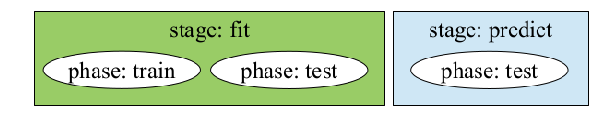

In [28]:
VISIM = cv2.imread('support-material/fit-predict.png')[:, :, ::-1]
plt.figure(figsize=(10, 3)); plt.imshow(VISIM); plt.axis('off'); plt.show()

In [9]:
netspec = ds.NetSpecification([[128, 3, 32, 32], [128,]],
                               inputs=['data', 'labels'],
                               predict_inputs=['data'],
                               predict_input_shapes=[[128, 3, 32, 32]])
netspec.layers = _layers
MODEL = netspec.instantiate()
# Initialize the sidepaths so that they are as close to identity as possible.
for pname, pval in MODEL.params.items():
    if 'sidepath' in pname:
        w_ary = np.zeros((pval[0].data.shape[1], pval[0].data.shape[0]),
                         dtype='float32')
        w_ary[:, :pval[0].data.shape[1]] = np.eye(pval[0].data.shape[1])
        w_ary = w_ary.T
        pval[0].data[:] = w_ary.reshape(pval[0].data.shape)

Now we can fit the model to the CIFAR10 data. With this model, it is possible to reach state-of-the art performance (as of May 2016, meanwhile, there have been some simple improvements on the residual unit to push the score even further) with additional random patch cropping. A monitor doing this comes with barrista, and we will have a look at this powerful concept in the following part.

In [14]:
DATA_FOLDER = '/home/barrista/notebooks/support-material/mldata/'
import os
import skdata.cifar10 as skdc10
MEAN = None
if not os.path.exists(DATA_FOLDER):
    os.mkdir(DATA_FOLDER)

def cifar10_training_data():
    """Get the `CIFAR-10` training data."""
    global MEAN
    np.random.seed(1)
    view = skdc10.view.OfficialImageClassificationTask()
    permutation = np.random.permutation(range(50000))
    if MEAN is None:
        MEAN = view.train.x.reshape((50000 * 32 * 32, 3)).mean(axis=0)
    return ((view.train.x[:50000, :][permutation, :] - MEAN).
            transpose((0, 3, 1, 2)).astype('float32'),
            view.train.y[:50000][permutation].reshape((50000, 1)).astype('float32'))

def cifar10_test_data():
    """Get the `CIFAR-10` test data."""
    global MEAN
    np.random.seed(1)
    view = skdc10.view.OfficialImageClassificationTask()
    permutation = np.random.permutation(range(10000))
    if MEAN is None:
        MEAN = view.train.x.reshape((50000 * 32 * 32, 3)).mean(axis=0)
    return ((view.test.x[:10000, :][permutation, :] - MEAN).
            transpose((0, 3, 1, 2)).astype('float32'),
            view.test.y[:10000][permutation].reshape((10000, 1)).astype('float32'))


In [18]:
tr_data, tr_labels = cifar10_training_data()
te_data, te_labels = cifar10_test_data()
import barrista.solver as sv
import barrista.monitoring as mnt

MODEL.fit(50048,
          sv.AdamSolver(base_lr=0.1,
                        weight_decay=0.9),
              X={'data': tr_data, 'labels': tr_labels},
              X_val={'data': te_data, 'labels': te_labels},
              test_interval=50048,
              train_callbacks=[
                  mnt.ProgressIndicator(),
                  mnt.RotatingMirroringMonitor({'data': 0}, 0, 0.5)],
              shuffle=True)

ls: 2.3026|ac: 0.1328|:  17%|█▋        | 8448/50048 [04:04<20:44, 33.42it/s]Process PoolWorker-1:
Process PoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return recv()
    return recv()
KeyboardInterrupt
Keyb

KeyboardInterrupt: 

### Exercise 2

* Create an MNIST classifier with fit and predict configurations,

* create a unit of `InnerProduct` followed by `MaxPooling` layers. Stack this unit five times to produce an MNIST classifier directly from it's pooling output. You'll have to explicitly take care to end up with an output of exactly 1x1 (which will be the response of the classifier),

* train and test your classifier on MNIST data.

----------------------------------

## Part 5 - Monitoring tools

For this training, I provided well-configured hyperparameters. Usually, they must be evaluated by grid search, and additional to performance graphs, layer visualizations can be helpful. Not only for this, but also for data-loading of the network, barrista heavily relies on `Monitor`s.

They are callbacks implemented with an inheritance-based signal/slot design pattern: they all inherit from a `Monitor` abstract class, providing empty slot implementations, and can override required slots to add a certain activity. Additionally, they can be executed in parallel to the current batch optimization process if they inherit from `ParallelDataMonitor`, which reduces the data preparation time in normal cases to ~1ms. Below, you can find an illustrative chart of the procedure:

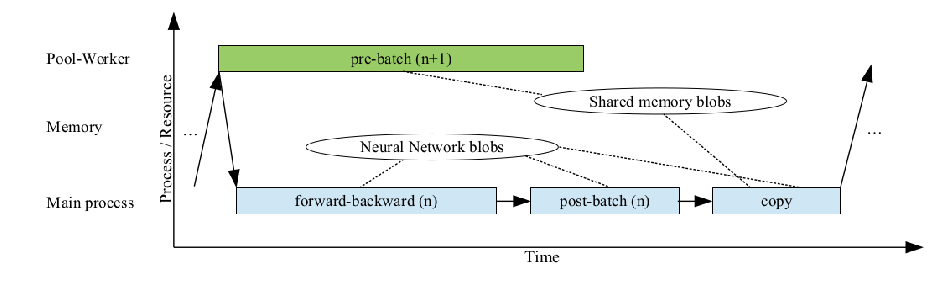

In [24]:
visim = cv2.imread('/home/barrista/notebooks/support-material/parallelism-scheme.png')[:, :, ::-1]
plt.figure(figsize=(16, 7)); plt.imshow(visim); plt.axis('off'); plt.show()

All monitor methods, e.g., `post_train_batch`, are run when the respective event ocucurs and receive a `kwargs` dictionary. Since this is using call-by-reference, it allows to alter the arguments. Hence, the order in which monitors are configured plays a role.

The network is available as `kwargs['net']` or `kwargs['testnet']`, depending on the event, and can be altered. (`ParallelDataMonitors` can write the the net's blobs as usual, they are copied to the real network when required). `kwargs['solver']` containes the solver object, `kwargs['batch_size']` the batch size and `kwargs['iteration']` the current iteration. There are more parameters depending on the callback type, please find them in the documentation.

### Exercise 3

* Create a monitor that writes the output of the last network layer to a .npz file every `n` iterations. If you need inspiration, look at the monitor implementations in the module `barrista.monitoring`.